# Generalized Linear Models : Pynapple & Nemos

In [1]:
## dandi_download_open - > remove this before uploading

import h5py
import os
import remfile

from random import randint

from dandi import download
from dandi import dandiapi
from pynwb import NWBHDF5IO


# downloads an NWB file from DANDI to download_loc, opens it, and returns the IO object for the NWB
# dandi_api_key is required to access files from embargoed dandisets
def dandi_download_open(dandiset_id, dandi_filepath, download_loc=None, dandi_api_key=None, force_overwrite=False):
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
    dandiset = client.get_dandiset(dandiset_id)

    file = dandiset.get_asset_by_path(dandi_filepath)
    file_url = file.download_url

    if download_loc == None:
        if "codeocean" in os.environ.get("GIT_ASKPASS", ""):
            download_loc = "../../scratch"
        else:
            download_loc = "."

    filename = dandi_filepath.split("/")[-1]
    filepath = f"{download_loc}/{filename}"

    if os.path.exists(filepath) and not force_overwrite:
        print("File already exists")
    else:
        download.download(file_url, output_dir=download_loc)
        print(f"Downloaded file to {filepath}")

    print("Opening file")
    io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
    return io


# streams an NWB file remotely from DANDI, opens it, and returns the IO object for the NWB
# dandi_api_key is required to access files from embargoed dandisets
def dandi_stream_open(dandiset_id, dandi_filepath, dandi_api_key=None):
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
    dandiset = client.get_dandiset(dandiset_id)

    file = dandiset.get_asset_by_path(dandi_filepath)
    base_url = file.client.session.head(file.base_download_url)
    file_url = base_url.headers["Location"]

    rem_file = remfile.File(file_url)
    h5py_file = h5py.File(rem_file, "r")
    io = NWBHDF5IO(file=h5py_file, mode="r", load_namespaces=True)
    return io

### Downloading file

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from scipy import interpolate
from functools import reduce

from scipy.optimize import minimize
from sklearn.metrics import r2_score

#%matplotlib inline

In [3]:
import pynapple as nap

In [4]:
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

### Pynapple

Open the nwb file with pynapple

In [5]:
import pynapple as nap
import nemos as nmo

io = dandi_download_open(dandiset_id, dandi_filepath, download_loc)
nwb = io.read()

#data = nap.NWBFile("sub-726298249_ses-754829445.nwb")
file_name = "sub-726298249_ses-754829445.nwb"
data = nap.load_file(file_name)

Request to https://api.dandiarchive.org/api failed (HTTPSConnectionPool(host='api.dandiarchive.org', port=443): Max retries exceeded with url: /api/info/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1391ed690>: Failed to resolve 'api.dandiarchive.org' ([Errno 8] nodename nor servname provided, or not known)")))
Using hard-coded URLs
HTTP connection failed
Traceback (most recent call last):
  File "/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/socket

ConnectionError: HTTPSConnectionPool(host='api.dandiarchive.org', port=443): Max retries exceeded with url: /api/dandisets/000021/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1391ff090>: Failed to resolve 'api.dandiarchive.org' ([Errno 8] nodename nor servname provided, or not known)"))

see data
explain different types of pynapple?

In [ ]:
data

sub-726298249_ses-754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ runn

### Extract Spiking data

In [ ]:
# Identify what brain location electrodes belong to
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

print(channel_probes)

units = data["units"]

# Add a new column to include location in our spikes TsGroup
units["location"] = units["peak_channel_id"].map(channel_probes)

# Filter units 1) inn VISp, 2) with "good" quality and 3) with a firing rate larger than 2
units_visp = units[(units["location"]=="VISp") & (units["quality"]=="good") & (units["rate"]>2.0)] 

# Spike counts will be arranged later

### Extract Stimulus Data

In [ ]:
def retrieve_stim_info(color_code, features, flashes):
    """Retrieve stimulus information based on color code.

    Parameters
    ----------
    color_code : 
        The color label (e.g., '-1.0' for black, '1.0 for white) to identify the stimulus.
    features : 
        An array indicating which flash interval each timestamp belongs to.

    Returns
    ----------
    color_feature: 
        A binary array where 1 indicates the timestamp falls within a flash 
        interval of the given color_code, and 0 otherwise.
    """
    # Get the indices of flash intervals where the color matches the given color_code
    intervals = flashes.index[flashes["color"] == color_code]
    # Initialize an array of zeros with the same length as the features array
    color_feature = np.zeros(len(features))
    # Create a boolean mask for entries in 'features' that match the target flash intervals
    mask = np.isin(features, intervals)
    # Mark the matching timestamps with 1
    color_feature[mask] = 1

    return color_feature

In [ ]:
flashes = data["flashes_presentations"]

# Set start, end and bin size
start = data["flashes_presentations"]["start"].min()
end = data["flashes_presentations"]["end"].max()
bin_sz = 0.050

# Set number of time bins
length = int((end-start)//bin_sz)

# Create Tsd with timestamps corresponding to the desired time bins and bins sizes
counts = units.count(bin_sz, ep=nap.IntervalSet(start, end))
uniform = nap.Tsd(t=counts.t, d=np.ones(counts.shape[0]))

# For each desired timestamp, find the index of the flash interval it falls into.
# Returns NaN for timestamps outside all intervals, and an index for those within.
features = flashes.in_interval(uniform)

white_stimuli = retrieve_stim_info("1.0", features, flashes)
black_stimuli = retrieve_stim_info("-1.0", features, flashes)

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/metadata_class.py:167: UserWarning: Metadata name 'size' overlaps with an existing attribute, and cannot be accessed as an attribute or key. Use 'get_info()' to access metadata.
  warnings.warn(


In [ ]:
# Plot
'''
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(uniform.times(), white_stimuli, color="silver")
axes[0].set_title("White Flashes from Session")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Presence of Flash")

axes[1].plot(uniform.times(), black_stimuli, color="black")
axes[1].set_title("Black Flashes from Session")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Presence of Flash")
'''

### Explain spike counts

In [ ]:
# Spike counts
# Provisional spike counts
drop_list = [k for k in units_visp.metadata_columns if k != "rate"]
units_visp.drop_info(drop_list)

spike_counts = units_visp.count(bin_sz, uniform.time_support)
spike_counts = spike_counts[:, :] # This is a problem idk why I am having the wrong dimensions
spike_counts

Time (s)        951765440    951765454    951765460    951765467    951765478    ...
--------------  -----------  -----------  -----------  -----------  -----------  -----
1285.650869922  0            2            1            4            0            ...
1285.700869922  0            1            1            3            0            ...
1285.750869922  0            0            0            3            0            ...
1285.800869922  0            0            2            1            0            ...
1285.850869922  0            1            0            2            0            ...
1285.900869922  0            2            1            0            0            ...
1285.950869922  0            1            0            3            0            ...
...             ...          ...          ...          ...          ...          ...
1583.750869922  0            0            0            1            0            ...
1583.800869922  1            1            0            1       

### Building design matrix

In [ ]:
### This will be in the snippet

def build_design_mat(stim, d, include_const=True):
  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d-1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  if include_const:
    constant = np.ones_like(stim)
    return np.column_stack([constant, X])
  return X

population GLM log-likelihood: -0.5633060233341309


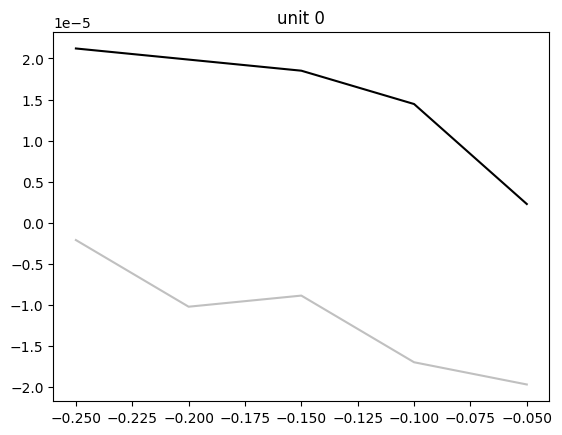

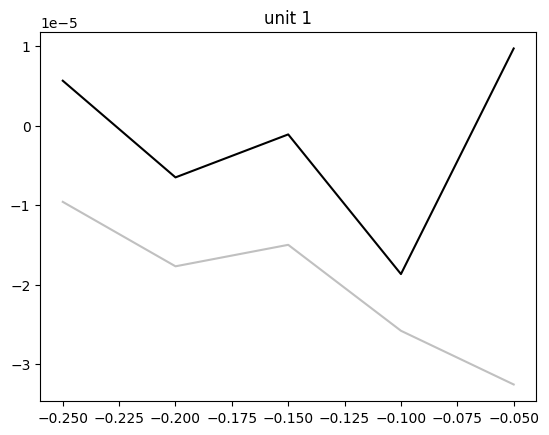

In [ ]:
# Attempt of basis
filter_duration = 0.250 # we want a 200 ms window,
filter_length = int(filter_duration / bin_sz) # divide by bin size to yield length of filter
filter_time_bins = np.linspace(-filter_duration, 0, filter_length+1, endpoint=True)

white_basis = nmo.basis.HistoryConv(window_size=5, label="white", conv_kwargs=dict(shift=False))
black_basis = nmo.basis.HistoryConv(window_size=5,label="black",conv_kwargs=dict(shift=False))

white_basis = white_basis.compute_features(white_stimuli)
black_basis = black_basis.compute_features(black_stimuli)

X = nmo.pytrees.FeaturePytree(W=white_basis, B=black_basis)

model = nmo.glm.PopulationGLM(regularizer="UnRegularized", )#regularizer_strength=10**-12
model.fit(X,spike_counts)

print(f"population GLM log-likelihood: {model.score(X, spike_counts)}")

for i in range(2):
    plt.plot(filter_time_bins[:-1], model.coef_["B"][:,i], label='Black flashes', color="black")
    plt.plot(filter_time_bins[:-1], model.coef_["W"][:,i], label='White flashes', color ="silver")
    plt.title(f"unit {i}")
    plt.show()


In [ ]:
from jax.tree_util import tree_leaves
X = nmo.pytrees.FeaturePytree(W=white_basis, B=black_basis)
X_1  = np.hstack(tree_leaves(X))
np.linalg.eigh(X_1[filter_length:].T@X_1[filter_length:])[0]


NameError: name 'white_basis' is not defined

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)

X = np.hstack([white_basis,black_basis])
spike_counts.sum(axis=0)
np.where(spike_counts.sum(axis=0)==1267)

model = nmo.glm.GLM(solver_name="LBFGS", solver_kwargs=dict(tol=10**-12))
model.fit(X,spike_counts[:,117])
print(model.coef_)
model.score(X,spike_counts[:,117])

[-1.85701429e-01  4.69274521e-01 -3.90083310e-01 -2.83405300e-11
 -2.70699128e-02 -2.99530466e-01  3.10134592e-01  6.34824141e-01
  6.85906181e-01  7.15288986e-02]


Array(-0.52314066, dtype=float64)

In [ ]:
X = np.hstack([white_basis,black_basis])
spike_counts.sum(axis=0)
#np.where(spike_counts.sum(axis=0)==1267)

model = nmo.glm.GLM()
model.fit(X,spike_counts[:,117])
print(model.solver_state_)
print(model.coef_)
model.score(X,spike_counts[:,117])

ProxGradState(iter_num=Array(39, dtype=int64, weak_type=True), stepsize=Array(16., dtype=float64), error=Array(0.00087914, dtype=float64), aux=None, velocity=(Array([-0.16936783,  0.44515027, -0.36249703, -0.03445257, -0.00520354,
       -0.298204  ,  0.3107426 ,  0.6225753 ,  0.70227602,  0.06478291],      dtype=float64), Array([-1.71907135], dtype=float64)), t=Array(21.26074369, dtype=float64, weak_type=True))
[-0.16475461  0.43639854 -0.356107   -0.03656973 -0.00425021 -0.30066662
  0.31082094  0.62583848  0.70305991  0.06173728]


Array(-0.52314407, dtype=float64)

In [ ]:
X = np.hstack([white_basis,black_basis])
spike_counts.sum(axis=0)
#np.where(spike_counts.sum(axis=0)==1267)

model = nmo.glm.GLM(solver_name="LBFGS", solver_kwargs=dict(tol=10**-12))
model.fit(X,spike_counts[:,117])
print(model.solver_state_)
print(model.coef_)
model.score(X,spike_counts[:,117])

LbfgsState(iter_num=Array(71, dtype=int64, weak_type=True), value=Array(0.51445397, dtype=float64), grad=(Array([ 1.32227637e-13,  2.61270972e-13, -2.04245387e-13, -1.88145852e-13,
       -5.23670462e-14,  3.61967726e-13, -1.27369686e-13, -1.98116371e-13,
       -4.57849904e-14, -1.65513003e-13], dtype=float64), Array([4.02502684e-13], dtype=float64)), stepsize=Array(1., dtype=float64), error=Array(7.37290318e-13, dtype=float64), s_history=(Array([[-5.62291880e-12, -5.09398079e-12,  3.20946048e-11,
         1.34884818e-11, -4.88719377e-11,  2.02595718e-11,
        -6.76103618e-12, -3.52919916e-11, -1.53749236e-11,
         4.64354943e-12],
       [ 3.32011335e-10, -1.48248525e-10, -2.83141011e-10,
         3.46141550e-10,  6.77931680e-10,  2.65495903e-10,
        -9.57549151e-10,  1.07929465e-09,  3.16378035e-11,
        -4.04004483e-10],
       [ 4.74643935e-11,  1.02605258e-10,  4.05752654e-11,
         9.40618708e-11,  4.14765711e-10,  6.02814465e-11,
        -8.92500185e-10,  7.821

Array(-0.52314066, dtype=float64)

In [ ]:
X = np.hstack([white_basis,black_basis])
spike_counts.sum(axis=0)
#np.where(spike_counts.sum(axis=0)==1267)

model = nmo.glm.PopulationGLM(solver_name="BFGS",solver_kwargs=dict(tol=10**-12))
model.fit(X,spike_counts)
print(model.solver_state_)
print(model.coef_[:,117])
print(model.coef_)


BfgsState(iter_num=Array(500, dtype=int64, weak_type=True), value=Array(0.48560891, dtype=float64), grad=(Array([[ 1.34801991e-06,  2.01335577e-06, -5.04130386e-06, ...,
        -6.75710692e-06,  2.17416404e-06,  8.86779281e-06],
       [ 9.14708196e-06,  6.88653395e-06, -8.77744525e-06, ...,
         6.68740359e-06, -1.84503566e-06,  4.87035747e-06],
       [ 7.59978915e-06,  2.23383972e-06, -1.53194115e-05, ...,
        -8.49725962e-08, -1.82249404e-06, -8.57963190e-06],
       ...,
       [-1.67306679e-05, -4.23216977e-07,  4.28802059e-06, ...,
        -1.38816003e-04, -5.14364827e-05,  7.29442942e-06],
       [-1.29317675e-05,  1.67401723e-05, -3.57584354e-06, ...,
        -1.05821860e-04, -4.62422737e-05,  7.29666048e-06],
       [-1.19039830e-06, -1.00563744e-05, -1.41807795e-05, ...,
        -9.02164312e-05, -3.19691462e-05,  7.31554964e-06]],      dtype=float64), Array([ 5.14515233e-08, -3.58877966e-06,  3.56340410e-06,  4.66792013e-05,
       -3.13083456e-09, -1.24029565e-05, 

In [ ]:
model.score(X,spike_counts, aggregate_sample_scores=lambda x : np.mean(x, axis=0))[117]

Array(-0.53958075, dtype=float64)

In [ ]:
X = np.hstack([white_basis,black_basis])
spike_counts.sum(axis=0)
#np.where(spike_counts.sum(axis=0)==1267)

model = nmo.glm.PopulationGLM(solver_name="GradientDescent",solver_kwargs=dict(tol=10**-12))
model.fit(X,spike_counts)
print(model.solver_state_)
print(model.coef_[:,117])
model.score(X,spike_counts)

ProxGradState(iter_num=Array(1, dtype=int64, weak_type=True), stepsize=Array(2., dtype=float64), error=Array(nan, dtype=float64), aux=None, velocity=(Array([[-2.09262426e-06, -9.57411271e-06,  5.89146548e-06, ...,
         6.60606982e-06, -2.22807066e-06, -8.84750392e-06],
       [-1.02044594e-05, -1.76859479e-05,  9.94738306e-06, ...,
        -6.91365546e-06,  1.82784693e-06, -4.79158633e-06],
       [-8.85248690e-06, -1.49820028e-05,  1.67072457e-05, ...,
        -1.53792821e-07,  1.82784693e-06,  8.72813895e-06],
       ...,
       [ 1.85153872e-05, -1.08674220e-06, -4.63847301e-06, ...,
         1.50161136e-04,  5.47613426e-05, -7.43392366e-06],
       [ 1.44594696e-05, -1.86623851e-05,  3.47336216e-06, ...,
         1.16361822e-04,  4.93534525e-05, -7.43392366e-06],
       [ 2.29171688e-06,  9.72903802e-06,  1.42891424e-05, ...,
         9.87861796e-05,  3.44817547e-05, -7.43392366e-06]],      dtype=float64), Array([-2.10816238e+00,  1.30051145e-01, -2.24703231e+00,  2.12861974e-0

Array(-0.56330602, dtype=float64)

(250.0, 260.0)

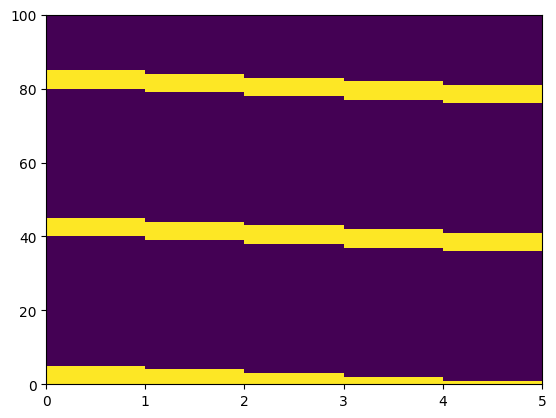

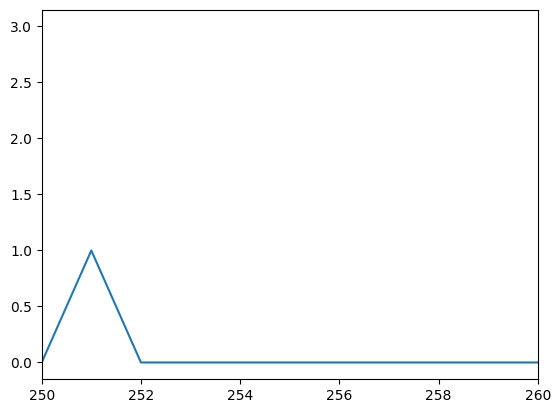

In [ ]:
plt.pcolormesh(X[5:105,5:][:,::-1])
plt.figure()
plt.plot(spike_counts[:500, 117].d)
plt.xlim(250, 260)

take firing rate prediction/time
calculate mean firing rate
compare mean firing rate of y

should be close

fit nemos to their exact data

In [6]:
plt.plot(white_basis)
plt.xlim([5900,5950])

NameError: name 'white_basis' is not defined